In [1]:
import pandas as pd
from tqdm import tqdm, tqdm_pandas
import glob
import os
import time
import ast
import numpy as np
import pickle
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
import matplotlib.ticker as mticker
from scipy.signal import savgol_filter
import plotly.express as px
import plotly.graph_objects as go
from scipy.signal import savgol_filter
tqdm.pandas()

In [2]:
pd.set_option('display.max_columns', 50)


In [3]:
TOTAL_DAYS = 400
START_POI = 0
END_POI = 400
TRAIN_RATIO = 0.7
VALID_RATIO = 0.2
TEST_RATIO = 1 - (TRAIN_RATIO + VALID_RATIO)
START_DATE = '2018-12-31'
WINDOW_SIZE = 168
HORIZON = 6

In [4]:
def get_merged_df(csv_path, start_row, end_row):

    #start = time.time()
    merge_df = pd.read_csv(csv_path)

    merge_df = merge_df.sort_values(by=['raw_visit_counts'], ascending=False)
    merge_df = merge_df.iloc[start_row:end_row]
    #print(merge_df)
    merge_df["visits_by_each_hour"] = merge_df["visits_by_each_hour"].apply(lambda x: ast.literal_eval(x))
    merge_df["visits_by_day"] = merge_df["visits_by_day"].apply(lambda x: ast.literal_eval(x))
    merge_df["visits_by_each_hour"] = merge_df["visits_by_each_hour"].apply(lambda x: x[:TOTAL_DAYS*24])
    merge_df["visits_by_day"] = merge_df["visits_by_day"].apply(lambda x: x[:TOTAL_DAYS])
    return merge_df

def masked_mae_np(preds, labels, null_val=0.):
    with np.errstate(divide='ignore', invalid='ignore'):
        if np.isnan(null_val):
            mask = ~np.isnan(labels)
        else:
            mask = np.not_equal(labels, null_val)
        mask = mask.astype('float32')
        mask /= np.mean(mask)
        #print(mask)
        mae = np.abs(np.subtract(preds, labels)).astype('float32')
        mae = np.nan_to_num(mae * mask)
        return np.mean(mae)

def masked_rmse_np(preds, labels, null_val=0.):
    return np.sqrt(masked_mse_np(preds=preds, labels=labels, null_val=null_val))


def masked_mse_np(preds, labels, null_val=0.):
    with np.errstate(divide='ignore', invalid='ignore'):
        if np.isnan(null_val):
            mask = ~np.isnan(labels)
        else:
            mask = np.not_equal(labels, null_val)
        mask = mask.astype('float32')
        mask /= np.mean(mask)
        rmse = np.square(np.subtract(preds, labels)).astype('float32')
        rmse = np.nan_to_num(rmse * mask)
        return np.mean(rmse)
    
def eval_by_day(preds, labels,num_series, days ):
    total_window_seris = preds.shape[0]
    assert num_series * days  ==  total_window_seris, f"preds shape is wrong, got: {total_window_seris} and {num_series} {days}"
    all_day_mae = []
    all_day_rmse = []
    for i in range(days):
        all_poi_per_day_preds = preds[i*num_series:(i+1)*num_series]
        all_poi_per_day_labels= labels[i*num_series:(i+1)*num_series]
        mae = masked_mae_np(all_poi_per_day_preds,all_poi_per_day_labels)
        rmse = masked_rmse_np(all_poi_per_day_preds,all_poi_per_day_labels)
        all_day_mae.append(mae)
        all_day_rmse.append(rmse)
    return all_day_mae, all_day_rmse

def eval_by_poi(preds, labels,num_series, days ):
    total_window_seris = preds.shape[0]
    assert num_series * days  ==  total_window_seris, f"preds shape is wrong, got: {total_window_seris} and {num_series} {days}"
    all_poi_mae = []
    all_poi_rmse = []
    for i in range(num_series):
        one_poi_all_day_preds = preds[i::num_series]
        one_poi_all_day_labels = labels[i::num_series]
        mae = masked_mae_np(one_poi_all_day_preds,one_poi_all_day_labels)
        rmse = masked_rmse_np(one_poi_all_day_preds,one_poi_all_day_labels)
        all_poi_mae.append(mae)
        all_poi_rmse.append(rmse)
    return all_poi_mae, all_poi_rmse

def plot_by_day(mae_per_day,rmse_per_day,time):
    x= time
    
    fig, ax = plt.subplots()
    
    myLocator = mticker.MultipleLocator(5)
    ax.xaxis.set_major_locator(myLocator)
    
    plt.plot(x,mae_per_day,'s-',label = 'mae')
    plt.plot(x,rmse_per_day,'o-',label = 'rmse')
    plt.xlabel('poi')
    plt.ylabel('metrics')
    plt.legend(loc ="best")
    plt.title("rnn result")
    plt.show()

def plot_by_poi_id(mae_per_day,rmse_per_day):
    x= np.arange(len(mae_per_day))
    
    fig, ax = plt.subplots()
    plt.figure(figsize=(16, 10))
    #myLocator = mticker.MultipleLocator(300)
    #ax.xaxis.set_major_locator(myLocator)
    
    #plt.plot(x,mae_per_day,'s-',label = 'mae')
    #plt.plot(x,rmse_per_day,'o-',label = 'rmse')
    plt.plot(mae_per_day,label = 'mae')
    plt.plot(rmse_per_day,label = 'rmse')
    plt.xlabel('poi')
    plt.ylabel('metrics')
    plt.legend(loc ="best")
    plt.title("rnn result")
    plt.show()


def plot_by_poi_map(merge_df,value,clip_val):
    plt.figure(figsize=(16, 10))
    plt.scatter(merge_df.latitude, merge_df.longitude, s=3, c=value, cmap='coolwarm')
    plt.colorbar()

    plt.clim(0, clip_val) 


In [5]:
def masked_MAPE(v, v_, axis=None):
    '''
    Mean absolute percentage error.
    :param v: np.ndarray or int, ground truth.
    :param v_: np.ndarray or int, prediction.
    :param axis: axis to do calculation.
    :return: int, MAPE averages on all elements of input.
    '''
    # TODO: Remove this line
    v_ = np.where(v_<0, 0,v_)
    
    mask = (v < 1E-5)
    percentage = np.abs(v_ - v) / np.abs(v)
    percentage = np.where(percentage > 5, 5, percentage) # TODO remove this
    if np.any(mask):
        masked_array = np.ma.masked_array(percentage, mask=mask)  # mask the dividing-zero as invalid
        result = masked_array.mean(axis=axis)
        if isinstance(result, np.ma.MaskedArray):
            return result.filled(np.nan)
        else:
            return result
    return np.mean(percentage, axis).astype(np.float64)


def MAPE(v, v_, axis=None):
    '''
    Mean absolute percentage error.
    :param v: np.ndarray or int, ground truth.
    :param v_: np.ndarray or int, prediction.
    :param axis: axis to do calculation.
    :return: int, MAPE averages on all elements of input.
    '''
    # TODO: Remove this line
    v_ = np.where(v_<0, 0,v_)
    mape = (np.abs(v_ - v) / np.abs(v)+1e-5).astype(np.float64)
    mape = np.where(mape > 5, 5, mape)
    return np.mean(mape, axis)


def RMSE(v, v_, axis=None):
    '''
    Mean squared error.
    :param v: np.ndarray or int, ground truth.
    :param v_: np.ndarray or int, prediction.
    :param axis: axis to do calculation.
    :return: int, RMSE averages on all elements of input.
    '''
    return np.sqrt(np.mean((v_ - v) ** 2, axis)).astype(np.float64)




def MAE(v, v_, axis=None):
    '''
    Mean absolute error.
    :param v: np.ndarray or int, ground truth.
    :param v_: np.ndarray or int, prediction.
    :param axis: axis to do calculation.
    :return: int, MAE averages on all elements of input.
    '''

    return np.mean(np.abs(v_ - v), axis).astype(np.float64)


def evaluate(y, y_hat, by_step=False, by_node=False):
    '''
    :param y: array in shape of [count, time_step, node].
    :param y_hat: in same shape with y.
    :param by_step: evaluate by time_step dim.
    :param by_node: evaluate by node dim.
    :return: array of mape, mae and rmse.
    '''
    if not by_step and not by_node:
        return masked_MAPE(y, y_hat), MAE(y, y_hat), RMSE(y, y_hat)
    if by_step and by_node:
        return masked_MAPE(y, y_hat, axis=0), MAE(y, y_hat, axis=0), RMSE(y, y_hat, axis=0)
    if by_step:
        return masked_MAPE(y, y_hat, axis=(0, 2)), MAE(y, y_hat, axis=(0, 2)), RMSE(y, y_hat, axis=(0, 2))
    if by_node:
        return masked_MAPE(y, y_hat, axis=(0, 1)), MAE(y, y_hat, axis=(0, 1)), RMSE(y, y_hat, axis=(0, 1))

In [6]:
csv_path_weekly = '/home/users/arash/datasets/safegraph/weekly_patterns_2018-12-31_2020-06-08_Houston.csv'
csv_poi_info = '/home/users/arash/datasets/safegraph/core_poi_info_2018-12-31_2020-06-08.csv'
weekly_patterns = get_merged_df(csv_path_weekly, START_POI, END_POI)
poi_info = pd.read_csv(csv_poi_info)
poi_df = pd.merge(weekly_patterns, poi_info, on='safegraph_place_id', how='inner')

In [36]:
pred_saved_path = f'../output/Chicago/train_{START_POI}_{END_POI}'
preds_data = np.genfromtxt(f'{pred_saved_path}/predict.csv', delimiter=',')
target_data = np.genfromtxt(f'{pred_saved_path}/target.csv', delimiter=',')

In [37]:
preds_data.shape

(1747, 400)

In [38]:
preds_data.shape

(1747, 400)

In [39]:
date_format = r'%Y-%m-%d'
start_time = datetime.strptime(START_DATE, date_format)
end_time = start_time + timedelta(days=TOTAL_DAYS)
start_time, end_time

(datetime.datetime(2018, 12, 31, 0, 0), datetime.datetime(2020, 2, 4, 0, 0))

In [40]:
time_span = pd.date_range(start_time, end_time, freq='1H', closed='left').to_numpy()
time_span

array(['2018-12-31T00:00:00.000000000', '2018-12-31T01:00:00.000000000',
       '2018-12-31T02:00:00.000000000', ...,
       '2020-02-03T21:00:00.000000000', '2020-02-03T22:00:00.000000000',
       '2020-02-03T23:00:00.000000000'], dtype='datetime64[ns]')

In [41]:
train_days = int(TRAIN_RATIO * TOTAL_DAYS)
valid_days = int(TOTAL_DAYS * VALID_RATIO)
test_days = TOTAL_DAYS - train_days - valid_days

In [42]:
valid_dates = time_span[train_days*24 + WINDOW_SIZE:(train_days + valid_days)*24 - HORIZON + 1]

In [43]:
preds_df = pd.DataFrame(index=valid_dates)

In [44]:
preds_df['predictions'] = pd.Series(list(preds_data), index=valid_dates)
preds_df['targets'] = pd.Series(list(target_data), index=valid_dates)

In [45]:
preds_df

,predictions,targets
2019-10-14 00:00:00,"[18.427779269849196, 24.89964482668958, 4.7542...","[12.00000296593872, 15.000000670598489, 11.000..."
2019-10-14 01:00:00,"[3.397238770718147, 21.355631715714118, -3.011...","[4.999998542836977, 14.00000082729153, 4.99999..."
2019-10-14 02:00:00,"[8.249203042052528, 27.43730003228923, -0.9993...","[0.9999960153502769, 26.999998790282085, 2.000..."
2019-10-14 03:00:00,"[42.6860055177863, 42.67343550063832, 12.04035...","[15.999996352401155, 27.99999863358905, 15.000..."
2019-10-14 04:00:00,"[90.80151440720735, 55.51151262616408, 35.4225...","[59.00000067032259, 46.00000086721782, 37.9999..."
...,...,...
2019-12-25 14:00:00,"[122.62263107063532, 86.56474390324813, 57.360...","[138.00000031255158, 106.99999889009783, 50.99..."
2019-12-25 15:00:00,"[118.58896729259486, 83.75570987946783, 56.814...","[77.00000061773244, 83.00000012367896, 35.9999..."
2019-12-25 16:00:00,"[160.99542148090535, 94.84663400294271, 69.935...","[152.0000000177308, 100.99999983025603, 66.000..."
2019-12-25 17:00:00,"[199.02686776295113, 114.19956411983684, 83.35...","[82.99999983845036, 99.0000001436421, 30.00000..."


In [46]:
evaluate(target_data, preds_data, by_node=True)

(0.7805792324496745, 3.0893405659511237, 8.379535071557106)

In [47]:
preds_data.shape

(1747, 400)

In [48]:
preds_data[:500].shape

(500, 400)

In [49]:
nodes_mape = masked_MAPE(target_data, preds_data, axis=0)

In [50]:
np.where(nodes_mape > 1)

(array([  5,  10,  12,  17,  20,  21,  23,  24,  25,  27,  28,  32,  35,
         37,  38,  39,  40,  51,  55,  58,  63,  68,  74,  76,  79,  91,
         95,  98, 102, 105, 112, 114, 115, 123, 133, 140, 147, 169, 190,
        198, 205, 208, 209, 223, 233, 234, 255, 262, 264, 268, 269, 277,
        278, 287, 293, 330, 366, 377, 383]),)

In [51]:
masked_MAPE(target_data, preds_data)

0.7805792324496745

In [52]:
MAE(target_data, preds_data)

3.0893405659511237

In [53]:
nodes_mape[nodes_mape > 1]

array([1.31852262, 1.07569612, 1.5340289 , 1.31659104, 1.41969063,
       1.13178379, 1.09395576, 1.46975449, 1.49481992, 1.54676019,
       1.00163221, 1.1993712 , 1.26771242, 1.2709003 , 2.22074809,
       1.24872053, 1.0853002 , 1.06347281, 1.04646655, 1.00316691,
       1.07257801, 1.41788964, 1.08171567, 1.53197699, 1.14517428,
       1.01799446, 1.3631893 , 1.09784229, 1.09002014, 1.43517434,
       1.59263429, 1.17893206, 1.04794615, 1.17041244, 1.38443738,
       1.33850019, 1.51714372, 1.02702378, 1.0284115 , 1.05265978,
       1.12616188, 1.10064048, 1.10231481, 1.40557575, 1.33629118,
       1.16893427, 1.21040587, 1.02280379, 1.07280161, 1.05943786,
       1.03508953, 1.12740306, 1.39937903, 1.09769389, 1.08768675,
       1.35021272, 1.04989224, 1.09221363, 1.06018798])

In [54]:
def plot_poi_ts(node_ind):
    plt.style.use('fivethirtyeight')
    fig, ax = plt.subplots(figsize=(16, 8))
    plt.plot(preds_df.index[-500:], preds_data[-500:, node_ind], label='pred', alpha=0.7)
    plt.plot(preds_df.index[-500:], target_data[-500:, node_ind], label='true', alpha=0.7)
    plt.legend()
    plt.style.use('fivethirtyeight')
    plt.grid(True)
    plt.tight_layout()
    # plt.xlabel('Time (Hour)')
    plt.ylabel('# of Visits')
    plt.title('Modified StemGNN - Third Worst POI Prediction')
    # plt.savefig(f"img/worst_mape_3.png", bbox_inches = 'tight')

In [55]:
masked_MAPE(target_data, preds_data, axis=0)

array([0.67491816, 0.49605721, 0.5175595 , 0.6851113 , 0.816759  ,
       1.31852262, 0.4819477 , 0.46431875, 0.62380711, 0.83934143,
       1.07569612, 0.96627998, 1.5340289 , 0.61675435, 0.9193966 ,
       0.9072307 , 0.99363289, 1.31659104, 0.9274806 , 0.68576128,
       1.41969063, 1.13178379, 0.87173159, 1.09395576, 1.46975449,
       1.49481992, 0.52156328, 1.54676019, 1.00163221, 0.60570713,
       0.68065874, 0.97976524, 1.1993712 , 0.93143273, 0.83412479,
       1.26771242, 0.74597958, 1.2709003 , 2.22074809, 1.24872053,
       1.0853002 , 0.87220203, 0.92970307, 0.55192483, 0.79816891,
       0.83319335, 0.89879951, 0.83564395, 0.49335874, 0.68653412,
       0.79019248, 1.06347281, 0.9201793 , 0.85292053, 0.68587757,
       1.04646655, 0.50510034, 0.68805938, 1.00316691, 0.52150225,
       0.73413463, 0.98925143, 0.85917055, 1.07257801, 0.82157766,
       0.75039118, 0.60538748, 0.68539411, 1.41788964, 0.67085198,
       0.97972352, 0.71301279, 0.59707353, 0.78911972, 1.08171

In [56]:
MAE(target_data, preds_data, axis=0)

array([26.94852031, 19.26937197, 12.77282007, 13.75586542,  4.94447226,
       13.02930425,  7.60992102,  8.35022803,  3.72734496, 10.07577346,
        9.60928343, 17.71803559,  9.83715888,  5.62580574, 11.27731393,
        7.36320932,  7.95906046,  3.97036607,  9.06654044,  4.30579225,
        7.22767414,  6.91346435, 10.08450448,  6.49213691,  8.28574085,
       10.72416651,  3.93880183,  7.78841818,  6.17822843,  3.61293849,
        5.42123939,  5.6961402 ,  6.12128201,  5.22449962,  6.05593869,
        2.34283357,  6.95126095,  6.28362426, 12.61602202,  5.66701546,
        5.66892671,  3.94678791,  3.76412366,  3.11497824,  3.50786096,
        5.43781811,  4.69937656,  4.06390196,  3.18487051,  3.7085683 ,
        3.25493016,  4.93262411,  4.68007506,  4.0450514 ,  3.29368877,
        4.77014177,  2.9712557 ,  4.26609225,  7.90761742,  2.86994432,
        3.84729314,  4.51106839,  4.6117735 ,  4.3379531 ,  4.34424722,
        5.14894158,  2.87079208,  2.85301789,  8.50985631,  3.14

In [57]:
preds_data.shape

(1747, 400)

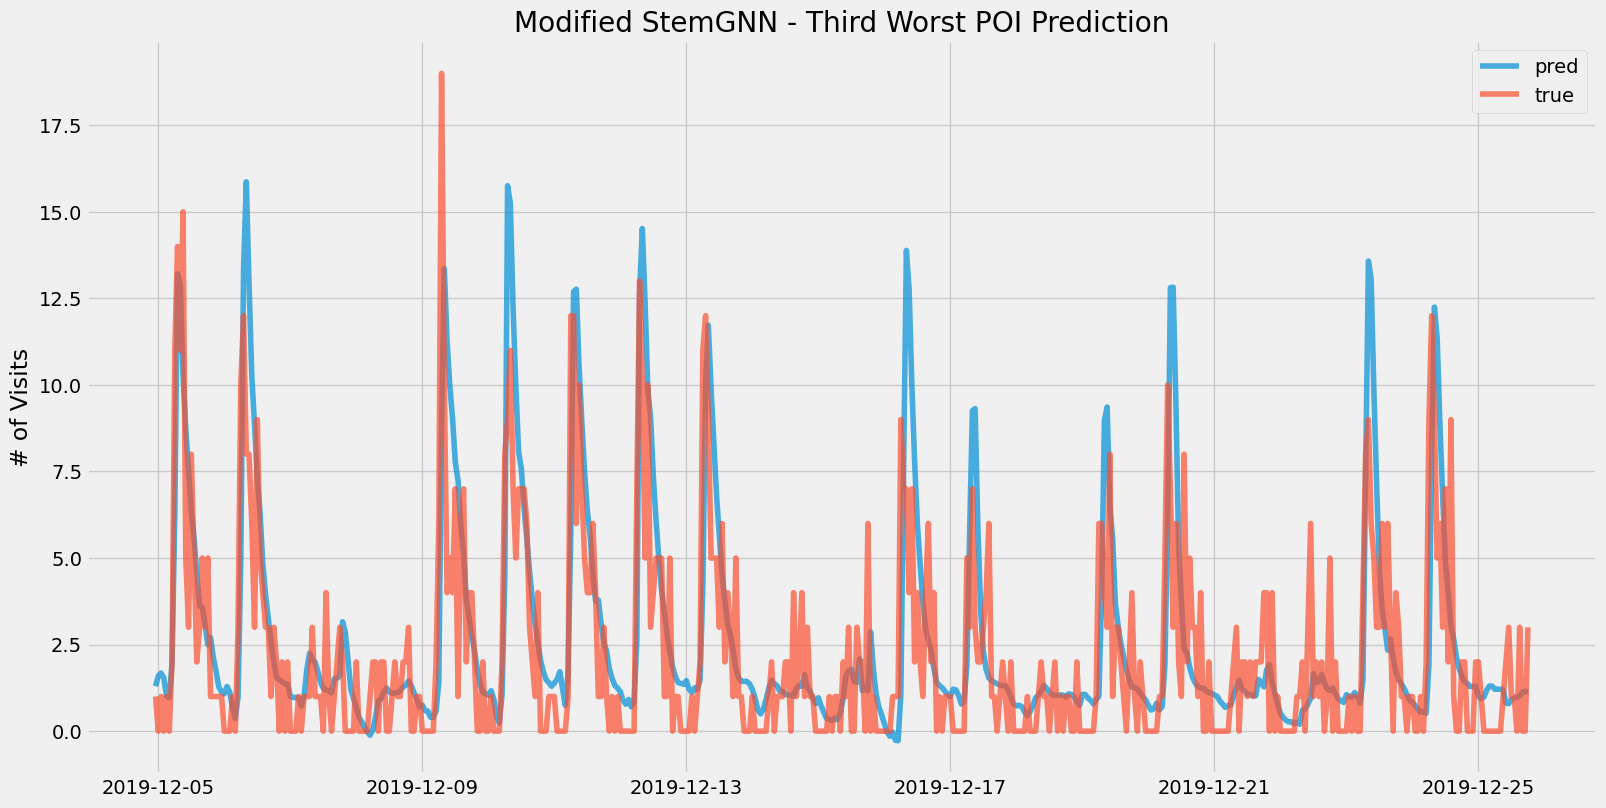

In [58]:
plot_poi_ts(333)

In [26]:
preds_data[:, 300].shape

(1747,)

Text(0.5, 1.0, 'Modified StemGNN - Third Worst POI Prediction')

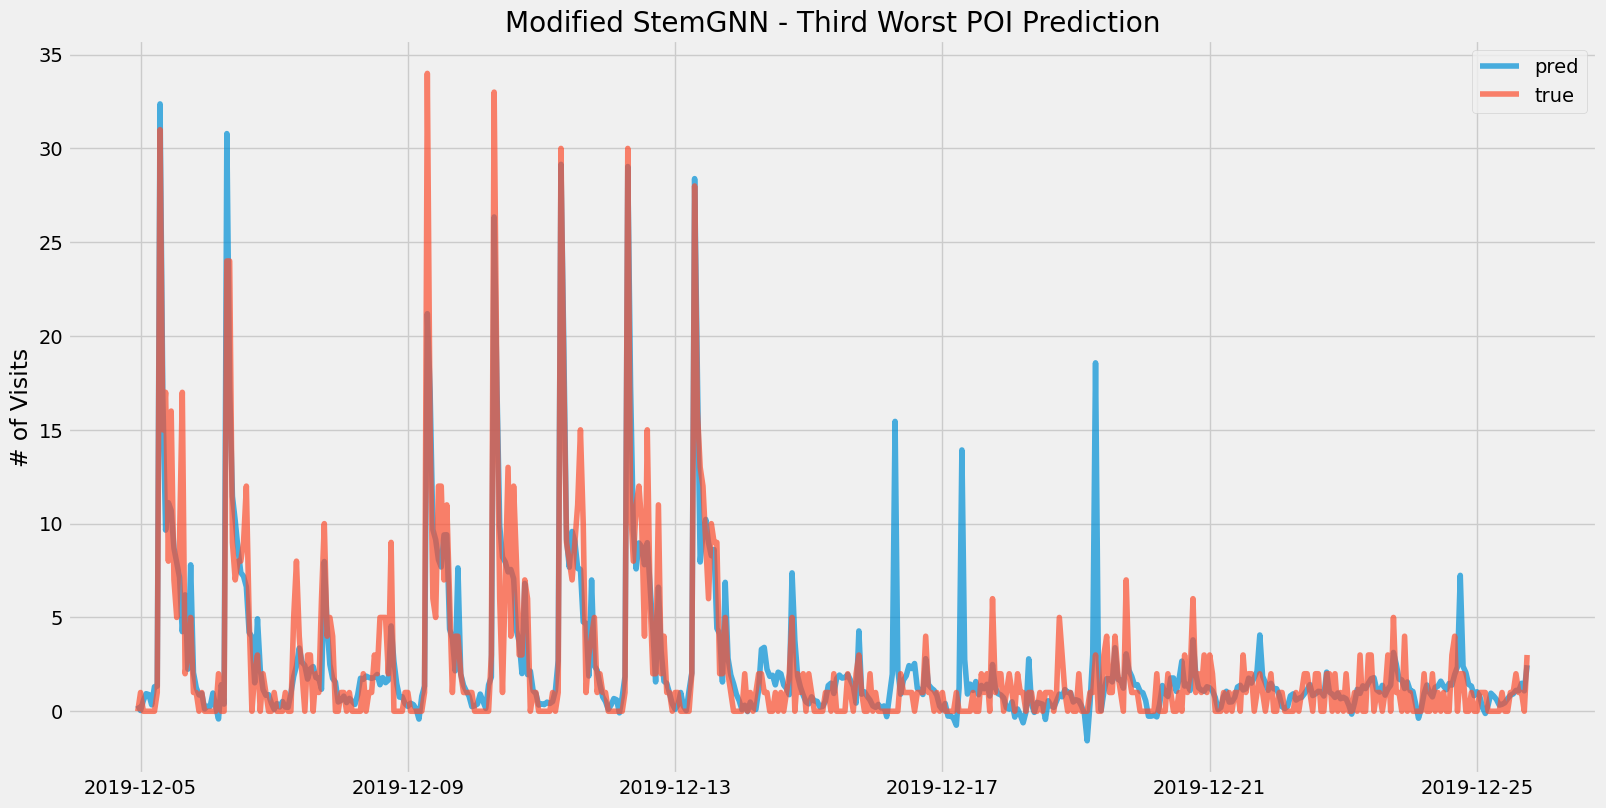

In [27]:
node_ind = 290
plt.style.use('fivethirtyeight')
fig, ax = plt.subplots(figsize=(16, 8))
plt.plot(preds_df.index[-500:], preds_data[-500:, node_ind], label='pred', alpha=0.7)
plt.plot(preds_df.index[-500:], target_data[-500:, node_ind], label='true', alpha=0.7)
plt.legend()
plt.style.use('fivethirtyeight')
plt.grid(True)
plt.tight_layout()
# plt.xlabel('Time (Hour)')
plt.ylabel('# of Visits')
plt.title('Modified StemGNN - Third Worst POI Prediction')
# plt.savefig(f"img/worst_mape_3.png", bbox_inches = 'tight')

Text(0.5, 1.0, 'Modified StemGNN Predictions for a Sample POI')

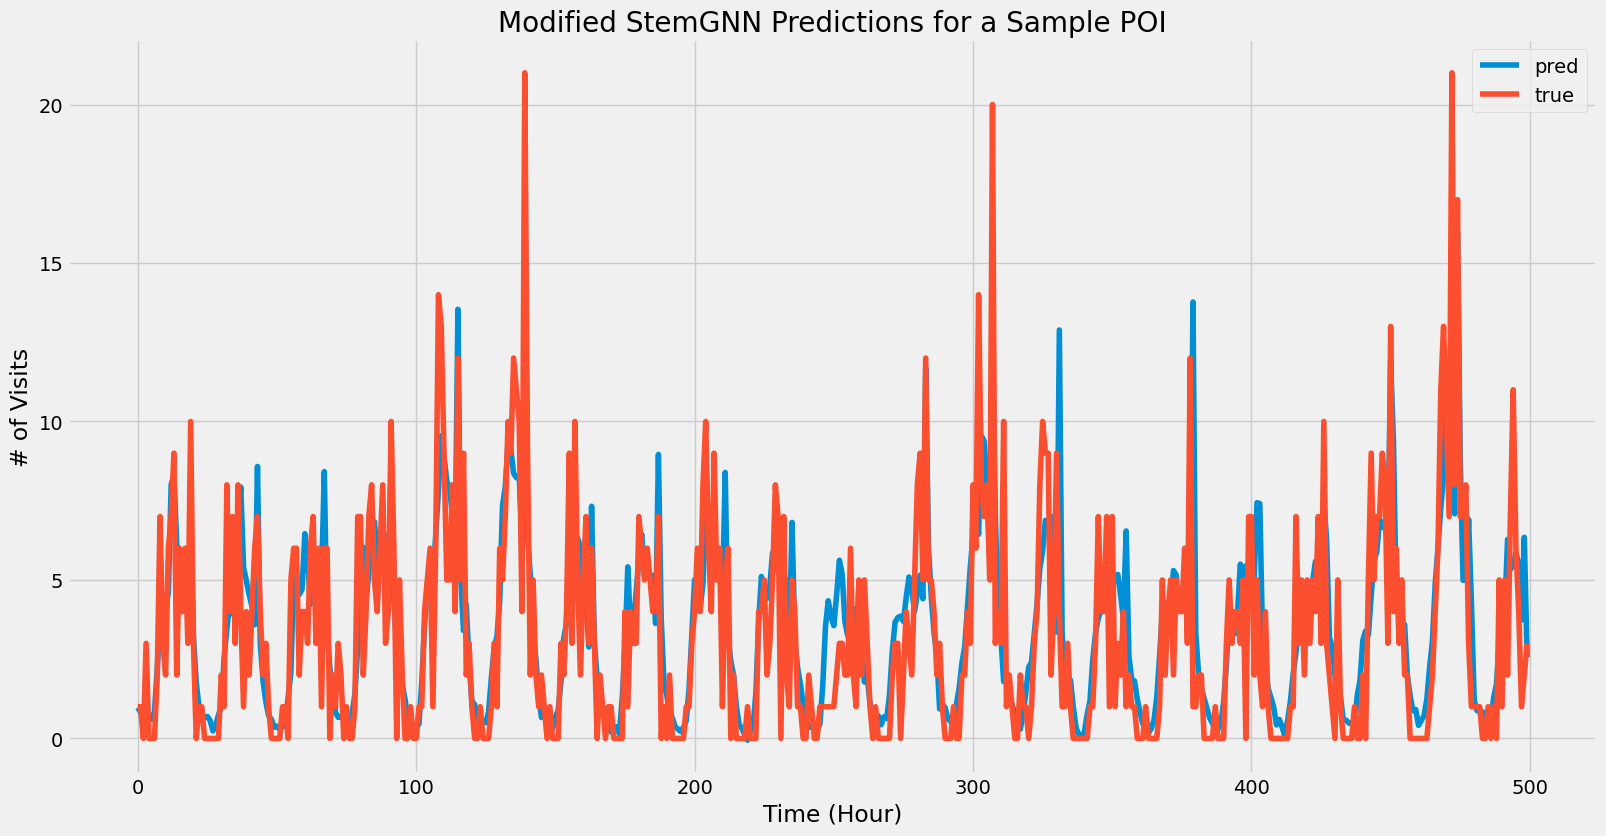

In [28]:
node_ind = 221
fig, ax = plt.subplots(figsize=(16, 8))
plt.style.use('fivethirtyeight')
plt.plot(preds_data[:500, node_ind], label='pred')
plt.plot(target_data[:500, node_ind], label='true')
plt.legend()
plt.style.use('fivethirtyeight')
plt.grid(True)
plt.tight_layout()
plt.xlabel('Time (Hour)')
plt.ylabel('# of Visits')
plt.title('Modified StemGNN Predictions for a Sample POI')
# plt.savefig(f"img/DeepLearning_Good_Result.png", bbox_inches = 'tight')

In [29]:
preds_df

,predictions,targets
2019-10-14 00:00:00,"[25.806852828330207, 23.693139372833286, 10.07...","[12.00000296593872, 15.000000670598489, 11.000..."
2019-10-14 01:00:00,"[14.35839636816661, 16.633087613164612, 7.7631...","[4.999998542836977, 14.00000082729153, 4.99999..."
2019-10-14 02:00:00,"[10.746293205502283, 15.384693750384145, 4.335...","[0.9999960153502769, 26.999998790282085, 2.000..."
2019-10-14 03:00:00,"[34.92998811206837, 31.45755119781429, 13.4627...","[15.999996352401155, 27.99999863358905, 15.000..."
2019-10-14 04:00:00,"[68.15731881431181, 44.07693979656102, 34.6429...","[59.00000067032259, 46.00000086721782, 37.9999..."
...,...,...
2019-12-25 14:00:00,"[132.51678432832597, 106.10966045516831, 56.52...","[138.00000031255158, 106.99999889009783, 50.99..."
2019-12-25 15:00:00,"[116.48543992981567, 86.93416727315659, 49.510...","[77.00000061773244, 83.00000012367896, 35.9999..."
2019-12-25 16:00:00,"[94.79812904257463, 84.4582542581361, 40.38419...","[152.0000000177308, 100.99999983025603, 66.000..."
2019-12-25 17:00:00,"[90.56509095553382, 64.61738015147043, 37.1999...","[82.99999983845036, 99.0000001436421, 30.00000..."


In [30]:
i = 0
mae_daily_arr = []
mape_daily_arr = []
for index, row in preds_df.iterrows():
    mae_daily_arr.append(MAE(row['predictions'], row['targets']))
    mape_daily_arr.append(masked_MAPE(row['predictions'], row['targets']))
mae_series = pd.Series(mae_daily_arr, index=preds_df.index)
mape_series = pd.Series(mape_daily_arr, index=preds_df.index)
preds_df['mae'] = mae_series
preds_df['mape'] = mape_series

In [31]:
preds_df

,predictions,targets,mae,mape
2019-10-14 00:00:00,"[25.806852828330207, 23.693139372833286, 10.07...","[12.00000296593872, 15.000000670598489, 11.000...",0.968356,1.086121
2019-10-14 01:00:00,"[14.35839636816661, 16.633087613164612, 7.7631...","[4.999998542836977, 14.00000082729153, 4.99999...",0.904744,1.077977
2019-10-14 02:00:00,"[10.746293205502283, 15.384693750384145, 4.335...","[0.9999960153502769, 26.999998790282085, 2.000...",0.974548,1.090865
2019-10-14 03:00:00,"[34.92998811206837, 31.45755119781429, 13.4627...","[15.999996352401155, 27.99999863358905, 15.000...",0.970869,1.068215
2019-10-14 04:00:00,"[68.15731881431181, 44.07693979656102, 34.6429...","[59.00000067032259, 46.00000086721782, 37.9999...",1.171696,0.929271
...,...,...,...,...
2019-12-25 14:00:00,"[132.51678432832597, 106.10966045516831, 56.52...","[138.00000031255158, 106.99999889009783, 50.99...",2.836741,0.751580
2019-12-25 15:00:00,"[116.48543992981567, 86.93416727315659, 49.510...","[77.00000061773244, 83.00000012367896, 35.9999...",3.038607,0.749112
2019-12-25 16:00:00,"[94.79812904257463, 84.4582542581361, 40.38419...","[152.0000000177308, 100.99999983025603, 66.000...",3.041007,0.705200
2019-12-25 17:00:00,"[90.56509095553382, 64.61738015147043, 37.1999...","[82.99999983845036, 99.0000001436421, 30.00000...",2.346853,0.752424


In [32]:
daily_errors = preds_df[['mape', 'mae']].resample('D').mean()
daily_errors

,mape,mae
2019-10-14,0.656349,2.471537
2019-10-15,0.654347,2.311594
2019-10-16,0.655977,2.257517
2019-10-17,0.636801,2.311883
2019-10-18,0.646164,2.329559
...,...,...
2019-12-21,0.676492,2.534020
2019-12-22,0.726419,2.338676
2019-12-23,0.670704,2.565872
2019-12-24,0.726991,2.802518


In [33]:
daily_errors.loc['10/7/2019':'10/21/2019']

,mape,mae
2019-10-14,0.656349,2.471537
2019-10-15,0.654347,2.311594
2019-10-16,0.655977,2.257517
2019-10-17,0.636801,2.311883
2019-10-18,0.646164,2.329559
2019-10-19,0.757015,2.291155
2019-10-20,0.807556,2.741719
2019-10-21,0.643514,2.377620


FileNotFoundError: [Errno 2] No such file or directory: 'img/paper/avg_mape_by_day.png'

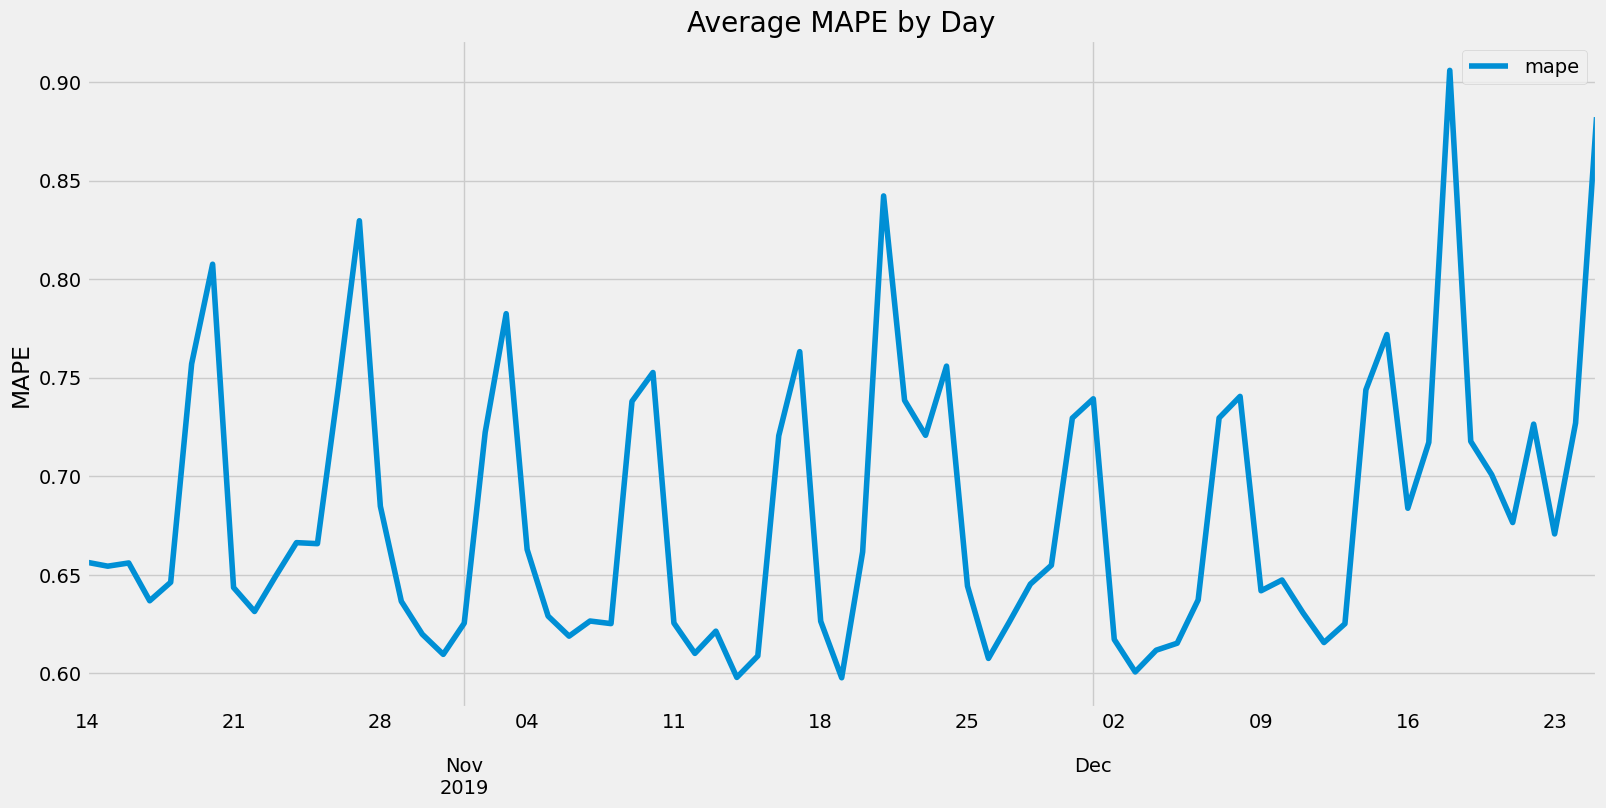

In [34]:
fig, ax = plt.subplots(figsize=(16, 8))
plt.style.use('fivethirtyeight')
daily_errors['mape'].plot()
plt.legend()
plt.style.use('fivethirtyeight')
plt.grid(True)
plt.tight_layout()
# plt.xlabel('Time (Hour)')
plt.ylabel('MAPE')
plt.title('Average MAPE by Day')
plt.savefig(f"img/paper/avg_mape_by_day.png", bbox_inches = 'tight')

FileNotFoundError: [Errno 2] No such file or directory: 'img/avg_mae_by_day.png'

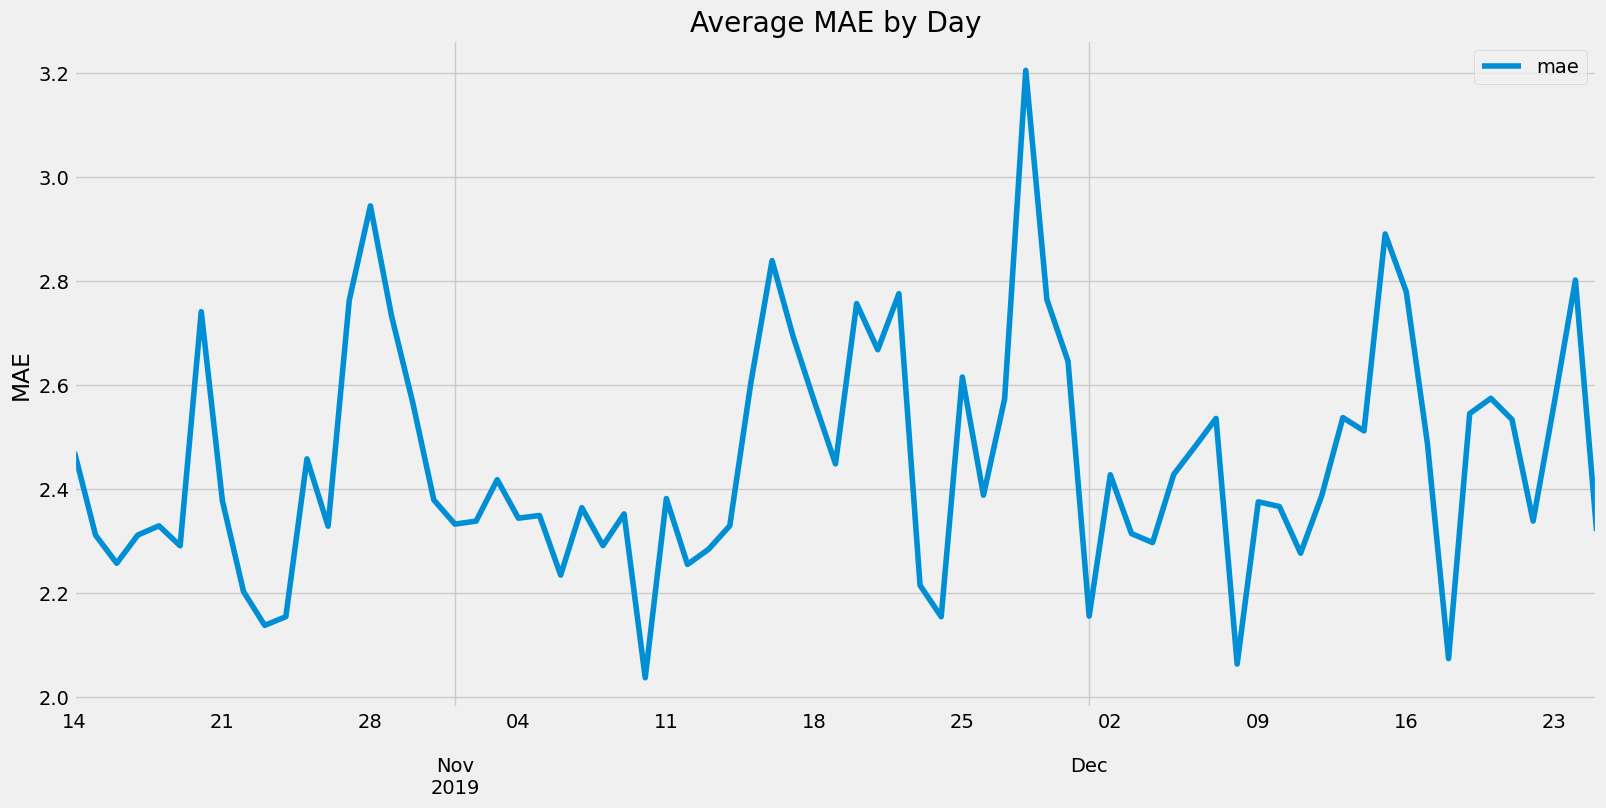

In [35]:
fig, ax = plt.subplots(figsize=(16, 8))
plt.style.use('fivethirtyeight')
daily_errors['mae'].plot()
plt.legend()
plt.style.use('fivethirtyeight')
plt.grid(True)
plt.tight_layout()
# plt.xlabel('Time (Hour)')
plt.ylabel('MAE')
plt.title('Average MAE by Day')
plt.savefig(f"img/avg_mae_by_day.png", bbox_inches = 'tight')

In [36]:
poi_df

,safegraph_place_id,visits_by_day,visits_by_each_hour,raw_visit_counts,location_name,street_address,city,region,postal_code,iso_country_code,safegraph_brand_ids,brands
0,sg:4cc165ff43ec4ce29e9dbe0732267ab1,"[6428, 6911, 8643, 8195, 7936, 7265, 8236, 614...","[74, 42, 23, 123, 220, 284, 338, 311, 493, 331...",3626878,George Bush Intercontinental Airport,2800 N Terminal Rd,Houston,TX,77032,US,NaN,NaN
1,sg:e8af4e248bbf41549aaec725d038ee42,"[2681, 3062, 3678, 3380, 3220, 3136, 3435, 255...","[23, 16, 8, 34, 72, 107, 143, 148, 212, 112, 1...",1448988,American Express Centurion Lounge,2800 N Terminal Rd Terminal D,Houston,TX,77032,US,NaN,NaN
2,sg:01cebfb757224fbd8151ee6ac6b0d679,"[3688, 3007, 3308, 3478, 3947, 4036, 2419, 212...","[8, 1, 4, 3, 5, 12, 18, 50, 61, 102, 158, 239,...",1380483,Simon mall,5085 Westheimer Rd,Houston,TX,77056,US,SG_BRAND_0a3c99595c9d3fddfece9c4e7607e5b3,Simon mall
3,sg:73e44ffdbcb24363bf01b6158373b9f3,"[2479, 2866, 3465, 3178, 3023, 2940, 3209, 240...","[19, 12, 8, 31, 67, 98, 127, 136, 192, 108, 16...",1350310,George Bush Intercontinental Airport Terminal E,3950 S Terminal Terminal E,Houston,TX,77066,US,NaN,NaN
4,sg:360d88ef2ced4be180ea24290b9f9df4,"[2410, 2607, 3235, 2913, 2806, 2217, 3011, 217...","[28, 45, 53, 36, 94, 116, 104, 132, 103, 189, ...",1240632,William P Hobby Airport,7800 Airport Blvd,Houston,TX,77061,US,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
395,sg:18b3905a242544279285792988b7e502,"[94, 77, 93, 86, 113, 133, 98, 78, 89, 72, 94,...","[0, 0, 0, 0, 0, 0, 0, 1, 1, 6, 6, 10, 12, 12, ...",48653,Target,300 Meyerland Plaza Mall,Houston,TX,77096,US,SG_BRAND_42aefbae01d2dfd981f7da7d823d689e,Target
396,sg:96ff5ed1e94843658944043e3843ebf5,"[145, 76, 99, 97, 80, 75, 89, 75, 90, 84, 91, ...","[0, 0, 0, 0, 0, 0, 1, 0, 1, 7, 11, 7, 14, 8, 1...",48540,Kroger,12222 Jones Rd,Houston,TX,77070,US,SG_BRAND_1f852a23da4b7250,Kroger
397,sg:748292b1cf674382925052a9a9a0946a,"[4, 0, 39, 23, 30, 6, 8, 26, 42, 44, 51, 60, 3...","[0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, ...",48305,Einstein Brothers,3551 Cullen Blvd,Houston,TX,77204,US,SG_BRAND_865a3b4c9e4f9d136714c4c6a5eded67,Einstein Brothers
398,sg:b65354230b3842c8b23144a0997a62d7,"[0, 0, 0, 4, 5, 9, 9, 7, 204, 158, 162, 178, 7...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",48134,Ulrich Int,10103 Spring Cypress Rd,Houston,TX,77070,US,NaN,NaN


In [37]:
nodes_mape = masked_MAPE(preds_data, target_data, axis=0)
nodes_mae = MAE(preds_data, target_data, axis=0)
nodes_mape_ser = pd.Series(nodes_mape, index=poi_df.index)
nodes_mae_ser = pd.Series(nodes_mae, index=poi_df.index)
poi_err_df = poi_df.copy()
poi_err_df['mape'] = nodes_mape_ser
poi_err_df['mae'] = nodes_mae_ser
poi_err_df

,safegraph_place_id,visits_by_day,visits_by_each_hour,raw_visit_counts,location_name,street_address,city,region,postal_code,iso_country_code,safegraph_brand_ids,brands,mape,mae
0,sg:4cc165ff43ec4ce29e9dbe0732267ab1,"[6428, 6911, 8643, 8195, 7936, 7265, 8236, 614...","[74, 42, 23, 123, 220, 284, 338, 311, 493, 331...",3626878,George Bush Intercontinental Airport,2800 N Terminal Rd,Houston,TX,77032,US,NaN,NaN,0.278773,19.359222
1,sg:e8af4e248bbf41549aaec725d038ee42,"[2681, 3062, 3678, 3380, 3220, 3136, 3435, 255...","[23, 16, 8, 34, 72, 107, 143, 148, 212, 112, 1...",1448988,American Express Centurion Lounge,2800 N Terminal Rd Terminal D,Houston,TX,77032,US,NaN,NaN,0.249718,14.446909
2,sg:01cebfb757224fbd8151ee6ac6b0d679,"[3688, 3007, 3308, 3478, 3947, 4036, 2419, 212...","[8, 1, 4, 3, 5, 12, 18, 50, 61, 102, 158, 239,...",1380483,Simon mall,5085 Westheimer Rd,Houston,TX,77056,US,SG_BRAND_0a3c99595c9d3fddfece9c4e7607e5b3,Simon mall,0.261701,9.309455
3,sg:73e44ffdbcb24363bf01b6158373b9f3,"[2479, 2866, 3465, 3178, 3023, 2940, 3209, 240...","[19, 12, 8, 31, 67, 98, 127, 136, 192, 108, 16...",1350310,George Bush Intercontinental Airport Terminal E,3950 S Terminal Terminal E,Houston,TX,77066,US,NaN,NaN,0.333398,8.904031
4,sg:360d88ef2ced4be180ea24290b9f9df4,"[2410, 2607, 3235, 2913, 2806, 2217, 3011, 217...","[28, 45, 53, 36, 94, 116, 104, 132, 103, 189, ...",1240632,William P Hobby Airport,7800 Airport Blvd,Houston,TX,77061,US,NaN,NaN,0.377076,5.257745
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
395,sg:18b3905a242544279285792988b7e502,"[94, 77, 93, 86, 113, 133, 98, 78, 89, 72, 94,...","[0, 0, 0, 0, 0, 0, 0, 1, 1, 6, 6, 10, 12, 12, ...",48653,Target,300 Meyerland Plaza Mall,Houston,TX,77096,US,SG_BRAND_42aefbae01d2dfd981f7da7d823d689e,Target,0.861525,2.591748
396,sg:96ff5ed1e94843658944043e3843ebf5,"[145, 76, 99, 97, 80, 75, 89, 75, 90, 84, 91, ...","[0, 0, 0, 0, 0, 0, 1, 0, 1, 7, 11, 7, 14, 8, 1...",48540,Kroger,12222 Jones Rd,Houston,TX,77070,US,SG_BRAND_1f852a23da4b7250,Kroger,0.778297,1.203344
397,sg:748292b1cf674382925052a9a9a0946a,"[4, 0, 39, 23, 30, 6, 8, 26, 42, 44, 51, 60, 3...","[0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, ...",48305,Einstein Brothers,3551 Cullen Blvd,Houston,TX,77204,US,SG_BRAND_865a3b4c9e4f9d136714c4c6a5eded67,Einstein Brothers,0.747149,1.359008
398,sg:b65354230b3842c8b23144a0997a62d7,"[0, 0, 0, 4, 5, 9, 9, 7, 204, 158, 162, 178, 7...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",48134,Ulrich Int,10103 Spring Cypress Rd,Houston,TX,77070,US,NaN,NaN,0.749550,1.441932


In [39]:
class bounding_box:
    def __init__(self, _lat_min, _lon_min,_lat_max,_lon_max):
        self.lat_min = _lat_min
        self.lon_min = _lon_min
        self.lat_max = _lat_max
        self.lon_max = _lon_max


class stat_collector:
    def __init__(self):
        self.parquet_file_count=0
        self.data_record_count = 0
        self.memory_usage_in_GB = 0		#gives an estimate of the total RAM usage if all files were read into memory at the same time.
        self.unique_device_count = 0
        self.avg_pos_acc = 0
        self.starting_time = time.process_time()
        self.elapsed_time = time.process_time()
        self.unique_geohash_count = 0
        
def load_poi_db(HT_range=0.2, ht_lat=29.749907, ht_lon=-95.358421):
    HT_box = bounding_box(ht_lat - HT_range, ht_lon - HT_range, ht_lat + HT_range, ht_lon + HT_range)

    bbox = HT_box
    poi_folder = "/storage/dataset/poi_haowen/CoreRecords-CORE_POI-2019_03-2020-03-25/"
    poi_columns = ["safegraph_place_id", "parent_safegraph_place_id", "location_name", "safegraph_brand_ids", "brands",
                   "top_category", "sub_category", "naics_code", "latitude", "longitude", "street_address", "city",
                   "region", "postal_code", "iso_country_code", "phone_number", "open_hours", "category_tags"]
    files = os.listdir(poi_folder)


    poi_s = stat_collector()
    poi_db = pd.DataFrame(columns=poi_columns)
    for f in files:
        if f[-3:] == 'csv' and 'brand' not in f:
            print(f)
            df = pd.read_csv(poi_folder + f)
            df = df[
                (df['latitude'] > bbox.lat_min) & (df['latitude'] < bbox.lat_max) & (df['longitude'] > bbox.lon_min) & (
                            df['longitude'] < bbox.lon_max)]
            poi_db = poi_db.append(df, ignore_index=True, sort=False)
            poi_s.memory_usage_in_GB += df.memory_usage(deep=True).sum() / 1000000000
            poi_s.data_record_count += df.shape[0]
            poi_s.parquet_file_count += 1
    return poi_db, poi_s




def get_merged_df(csv_path,num=2000):

    start = time.time()
    merge_df = pd.read_csv(csv_path)
    print(merge_df.shape)

    merge_df = merge_df.sort_values(by=['raw_visit_counts'], ascending=False)
    merge_df = merge_df.head(num)
    merge_df["visits_by_each_hour"] = merge_df["visits_by_each_hour"].apply(lambda x: ast.literal_eval(x))
    merge_df["visits_by_day"] = merge_df["visits_by_day"].apply(lambda x: ast.literal_eval(x))


    end = time.time()
    print("pass {}".format(end-start))

    return merge_df

poi_db, poi_s = load_poi_db(HT_range=0.5)

core_poi-part2.csv
core_poi-part5.csv
core_poi-part4.csv
core_poi-part3.csv
core_poi-part1.csv


In [40]:
poi_err_df = poi_db.merge(poi_err_df, how='inner', on='safegraph_place_id')
poi_err_df.head()

,safegraph_place_id,parent_safegraph_place_id,location_name_x,safegraph_brand_ids_x,brands_x,top_category,sub_category,naics_code,latitude,longitude,street_address_x,city_x,region_x,postal_code_x,iso_country_code_x,phone_number,open_hours,category_tags,visits_by_day,visits_by_each_hour,raw_visit_counts,location_name_y,street_address_y,city_y,region_y,postal_code_y,iso_country_code_y,safegraph_brand_ids_y,brands_y,mape,mae
0,sg:7ef0e90c5cf94288932f30230d27413b,sg:30b8c7dc237343a1999af32ceb780216,Mattress Zone,NaN,NaN,Furniture Stores,Furniture Stores,442110.0,29.606161,-95.126548,3457 Clear Lake City Blvd Ste 600,Houston,TX,77059,US,1.832284e+10,NaN,NaN,"[280, 119, 150, 129, 165, 160, 257, 154, 120, ...","[0, 0, 0, 1, 1, 0, 2, 3, 5, 14, 22, 26, 22, 24...",94110,Mattress Zone,3457 Clear Lake City Blvd Ste 600,Houston,TX,77059,US,NaN,NaN,0.588227,2.185719
1,sg:91da6ceef49d40c1bc00f941cd8b2e36,NaN,El Franco Lee Park,NaN,NaN,"Museums, Historical Sites, and Similar Institu...",Nature Parks and Other Similar Institutions,712190.0,29.592129,-95.256530,9400 Hall Rd Houston Tx 77089,Houston,TX,77089,US,NaN,NaN,NaN,"[25, 23, 13, 29, 38, 49, 45, 37, 38, 121, 100,...","[0, 0, 0, 1, 0, 0, 0, 0, 1, 3, 0, 2, 7, 1, 2, ...",55116,El Franco Lee Park,9400 Hall Rd Houston Tx 77089,Houston,TX,77089,US,NaN,NaN,0.805500,2.677230
2,sg:0a53223d87a145839d0bd018b692a27c,NaN,Aloft Hotels,SG_BRAND_232e3a254ee6887688ed8957d9068679,Aloft Hotels,Traveler Accommodation,Hotels (except Casino Hotels) and Motels,721110.0,29.757500,-95.363559,820 Fannin St,Houston,TX,77002,US,1.713225e+10,"{ ""Mon"": [[""0:00"", ""24:00""]], ""Tue"": [[""0:00"",...",NaN,"[58, 36, 88, 131, 120, 22, 22, 143, 149, 149, ...","[1, 1, 0, 1, 0, 2, 3, 1, 5, 3, 0, 1, 1, 4, 2, ...",51393,Aloft Hotels,820 Fannin St,Houston,TX,77002,US,SG_BRAND_232e3a254ee6887688ed8957d9068679,Aloft Hotels,0.650820,1.695694
3,sg:9691698b74774e91ac102c60c09965a9,NaN,Houston Methodist Willowbrook Hospital,NaN,NaN,General Medical and Surgical Hospitals,General Medical and Surgical Hospitals,622110.0,29.967148,-95.551111,18220 State Highway 249,Houston,TX,77070,US,NaN,NaN,NaN,"[243, 186, 439, 478, 510, 255, 225, 428, 586, ...","[3, 4, 0, 1, 4, 6, 23, 15, 16, 15, 10, 17, 8, ...",236541,Houston Methodist Willowbrook Hospital,18220 State Highway 249,Houston,TX,77070,US,NaN,NaN,0.365180,4.680603
4,sg:d40fa53bcab347aca1e87f80a5727c83,NaN,Johnny Steele Dog Park,NaN,NaN,"Museums, Historical Sites, and Similar Institu...",Nature Parks and Other Similar Institutions,712190.0,29.760761,-95.397481,2929 Allen Pkwy,Houston,TX,77019,US,NaN,"{ ""Mon"": [[""7:00"", ""20:00""]], ""Tue"": [[""7:00"",...",NaN,"[48, 7, 168, 161, 160, 18, 10, 153, 224, 233, ...","[0, 0, 0, 1, 0, 2, 3, 6, 9, 9, 3, 3, 6, 2, 3, ...",67947,Johnny Steele Dog Park,2929 Allen Pkwy,Houston,TX,77019,US,NaN,NaN,0.762072,1.751816


In [66]:
def plot_map(df, save=False, file_name='fig1.png', metric='mape', max_size=15):
    fig = px.scatter_mapbox(df, lat="latitude", lon="longitude",
                            hover_name="location_name_x", 
                            hover_data=["raw_visit_counts", "street_address_x",
                                        'top_category', 'sub_category'],
                            color=metric, 
                            size=metric,
                            zoom=9.5,
                            size_max=max_size,
                            opacity=0.5,
                            height=700,
                            width = 1000
    )
    colorbar=dict(len=.75,
                    title=metric)
    fig.update_layout(mapbox_style="open-street-map")
    fig.update_layout(margin={"r":0,"t":0,"l":0,"b":0})
    fig.update_layout(coloraxis_colorbar=colorbar)
    fig.show()
    if save:
        fig.write_image(file_name, scale=3)

plot_map(poi_err_df, True, 'img/mape_by_POI.png', metric='mape')

In [67]:
plot_map(poi_err_df, True, 'img/mae_by_POI.png', metric='mae', max_size=50)

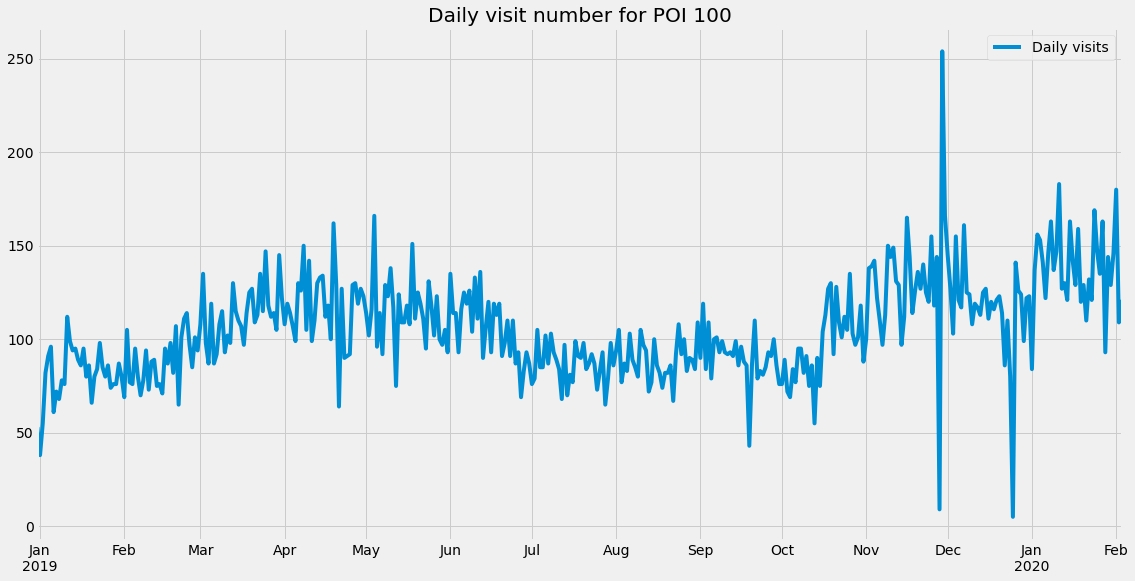

In [43]:
POI_IND = 100
date_range = pd.date_range(start=START_DATE, periods=TOTAL_DAYS)
poi_daily_visit_num = poi_err_df['visits_by_day'].iloc[POI_IND]
daily_visits = pd.Series(poi_daily_visit_num, index=date_range)
fig, ax = plt.subplots(figsize=(16, 8))
plt.style.use('fivethirtyeight')
daily_visits.plot(label='Daily visits')
plt.legend()
plt.style.use('fivethirtyeight')
plt.grid(True)
plt.tight_layout()
# plt.xlabel('Time (Hour)')
# plt.ylabel('# of Visits')
plt.title(f'Daily visit number for POI {POI_IND}')
plt.savefig(f"img/full_dataset_poi_{POI_IND}.png", bbox_inches = 'tight')

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Text(0.5, 1.0, 'Daily visit number for POI 100')

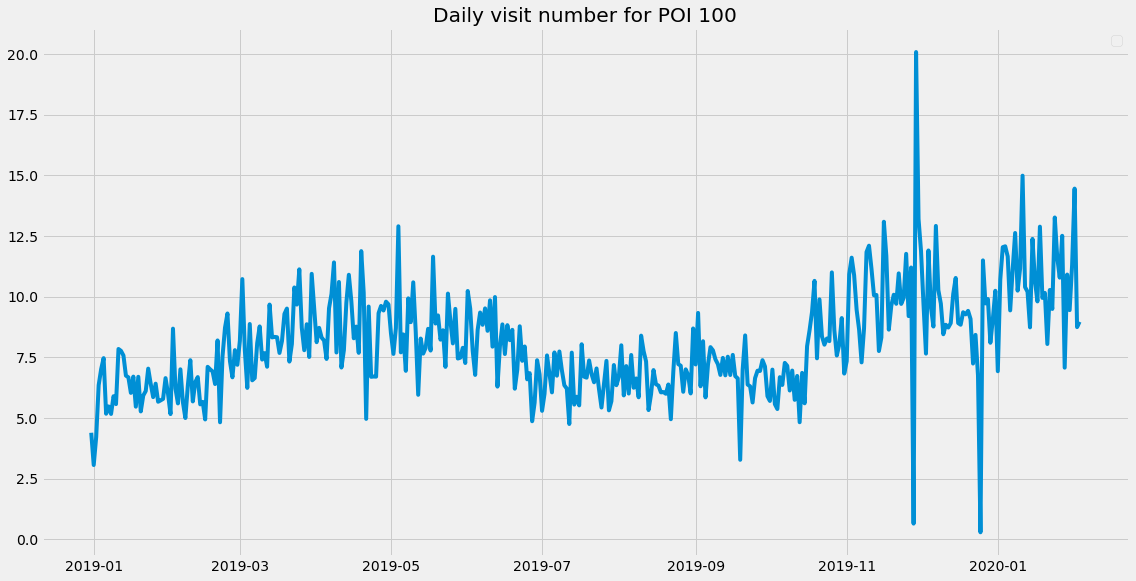

In [44]:
poi_hourly_visit_num = poi_err_df['visits_by_each_hour'].iloc[POI_IND]
date_range = pd.date_range(start=START_DATE, periods=TOTAL_DAYS*24, freq='1H')
hourly_visits = pd.Series(poi_hourly_visit_num, index=date_range)
plt.style.use('fivethirtyeight')
fig, ax = plt.subplots(figsize=(16, 8))
plt.plot(date_range[::24], savgol_filter(hourly_visits, 24, 2)[12::24], alpha=1)
# hourly_visits.plot(alpha=0.4)
plt.legend()
plt.grid(True)
plt.tight_layout()
# plt.xlabel('Time (Hour)')
# plt.ylabel('# of Visits')
plt.title(f'Daily visit number for POI {POI_IND}')
# plt.savefig(f"img/DeepLearning_Good_Result.png", bbox_inches = 'tight')

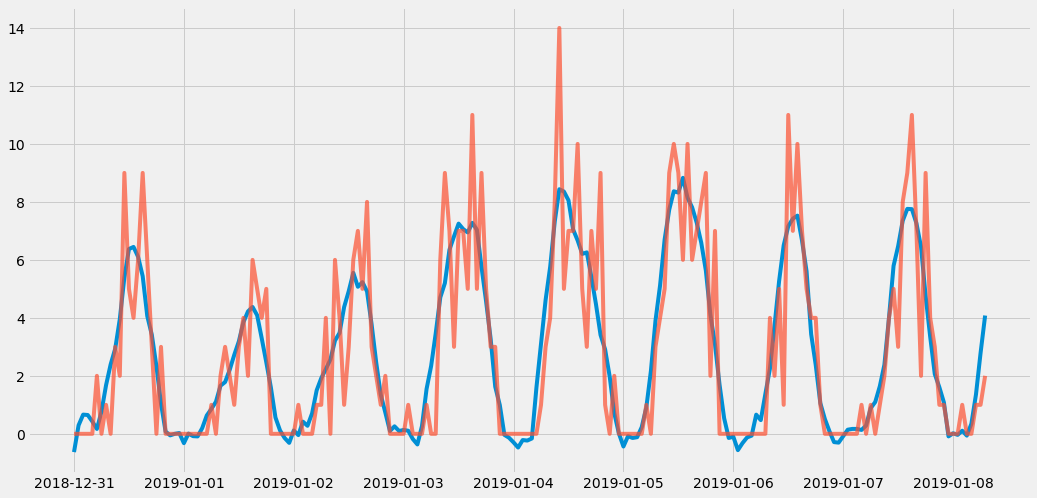

In [45]:
plt.style.use('fivethirtyeight')
fig, ax = plt.subplots(figsize=(16, 8))
plt.plot(date_range[:200], savgol_filter(hourly_visits, 12, 3)[:200], alpha=1)
plt.plot(date_range[:200], hourly_visits[:200], alpha=0.7)

In [46]:
poi_err_df['visits_by_each_hour'].apply(lambda x: savgol_filter(x, 12, 3))

0      [0.029304029304025907, 0.32101232101231875, 0....
1      [0.09890109890109733, 0.07292707292707273, 0.0...
2      [1.2307692307692333, 0.4755244755244782, 0.286...
3      [2.970695970695978, 1.462204462204469, 1.76590...
4      [0.9560439560439555, -0.670329670329673, -0.96...
                             ...                        
437    [0.23076923076923228, -0.0489510489510489, -0....
438    [3.886446886446894, 1.745587745587751, 1.21611...
439    [1.3663003663003674, 0.8518148518148526, 0.391...
440    [1.0952380952380967, 0.6796536796536792, 0.454...
441    [0.029304029304029797, -0.06360306360306284, -...
Name: visits_by_each_hour, Length: 442, dtype: object

### Checking the latest results against the original StemGNN

In [47]:
cur_pred_saved_path = f'/home/users/arash/NGA Project/POI/code/StemGNN/output/houston_data/train_{START_POI}_{END_POI}'
cur_preds_data = np.genfromtxt(f'{cur_pred_saved_path}/predict.csv', delimiter=',')
cur_target_data = np.genfromtxt(f'{cur_pred_saved_path}/target.csv', delimiter=',')
orig_pred_saved_path = f'/home/users/arash/NGA Project/POI_orig/POI/code/StemGNN/output/houston_data/train_{START_POI}_{END_POI}'
orig_preds_data = np.genfromtxt(f'{orig_pred_saved_path}/predict.csv', delimiter=',')
orig_target_data = np.genfromtxt(f'{orig_pred_saved_path}/target.csv', delimiter=',')

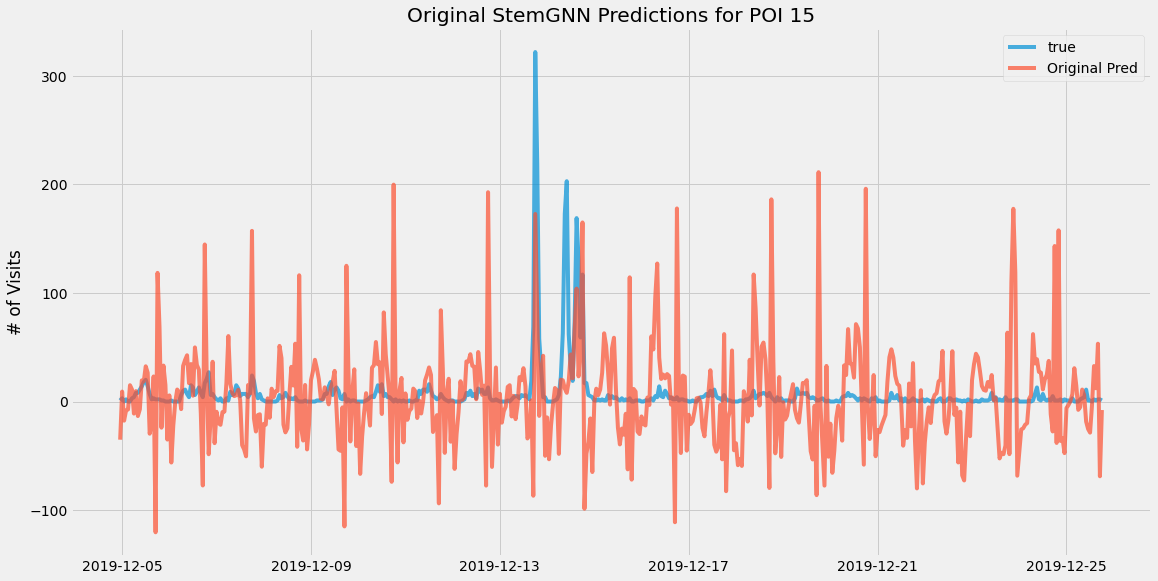

In [75]:
node_ind = 15
plt.style.use('fivethirtyeight')
fig, ax = plt.subplots(figsize=(16, 8))
plt.plot(preds_df.index[-500:], target_data[-500:, node_ind], label='true', alpha=0.7)
plt.plot(preds_df.index[-500:], orig_preds_data[-500:, node_ind], label='Original Pred', alpha=0.7)
# plt.plot(preds_df.index[-500:], cur_preds_data[-500:, node_ind], label='Modified Pred', alpha=0.7)
plt.legend()
plt.style.use('fivethirtyeight')
plt.grid(True)
plt.tight_layout()
# plt.xlabel('Time (Hour)')
plt.ylabel('# of Visits')
plt.title(f'Original StemGNN Predictions for POI {node_ind}')
plt.savefig(f"img/stem_gnn_comp_orig_1.png", bbox_inches = 'tight')

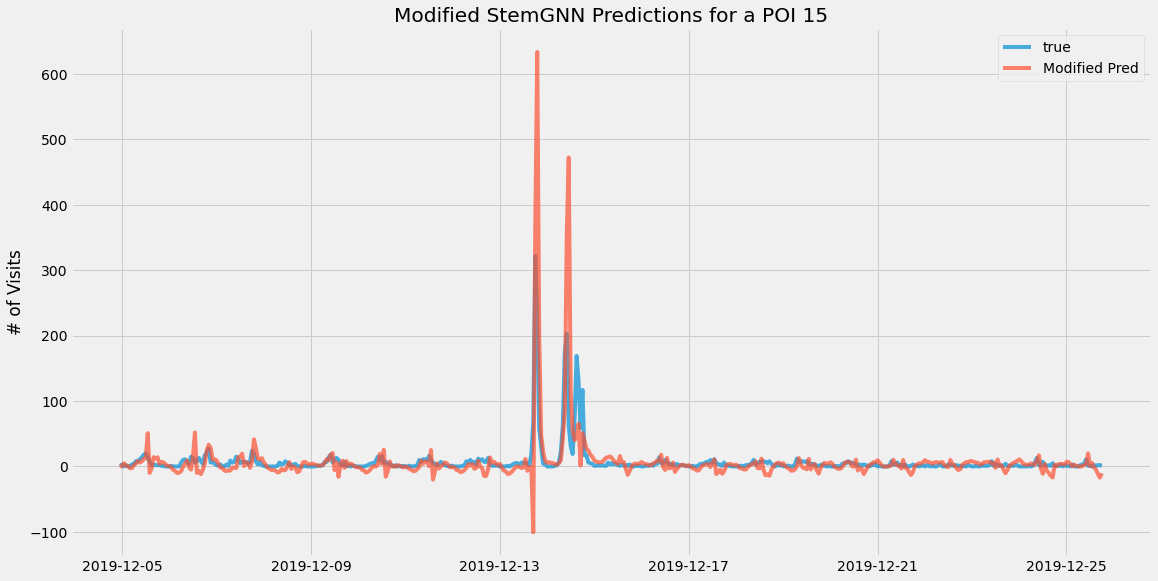

In [76]:
node_ind = 15
plt.style.use('fivethirtyeight')
fig, ax = plt.subplots(figsize=(16, 8))
plt.plot(preds_df.index[-500:], target_data[-500:, node_ind], label='true', alpha=0.7)
# plt.plot(preds_df.index[-500:], orig_preds_data[-500:, node_ind], label='Original Pred', alpha=0.7)
plt.plot(preds_df.index[-500:], cur_preds_data[-500:, node_ind], label='Modified Pred', alpha=0.7)
plt.legend()
plt.style.use('fivethirtyeight')
plt.grid(True)
plt.tight_layout()
# plt.xlabel('Time (Hour)')
plt.ylabel('# of Visits')
plt.title(f'Modified StemGNN Predictions for a POI {node_ind}')
plt.savefig(f"img/stem_gnn_comp_modified_1.png", bbox_inches = 'tight')

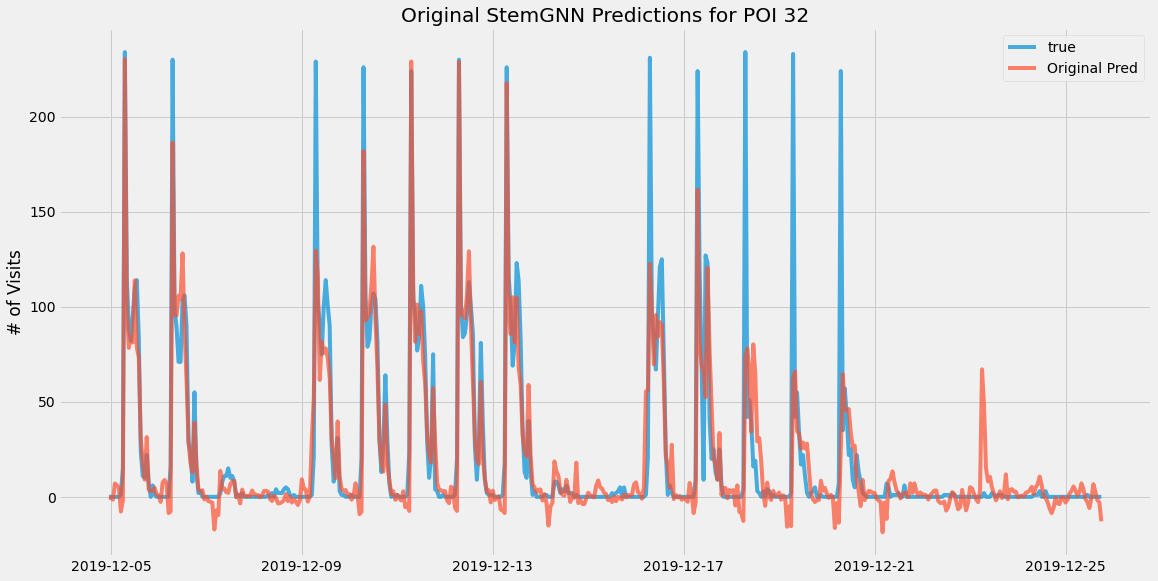

In [101]:
node_ind = 32
plt.style.use('fivethirtyeight')
fig, ax = plt.subplots(figsize=(16, 8))
plt.plot(preds_df.index[-500:], target_data[-500:, node_ind], label='true', alpha=0.7)
plt.plot(preds_df.index[-500:], orig_preds_data[-500:, node_ind], label='Original Pred', alpha=0.7)
# plt.plot(preds_df.index[-500:], cur_preds_data[-500:, node_ind], label='Modified Pred', alpha=0.7)
plt.legend()
plt.style.use('fivethirtyeight')
plt.grid(True)
plt.tight_layout()
# plt.xlabel('Time (Hour)')
plt.ylabel('# of Visits')
plt.title(f'Original StemGNN Predictions for POI {node_ind}')
plt.savefig(f"img/stem_gnn_comp_orig_2.png", bbox_inches = 'tight')

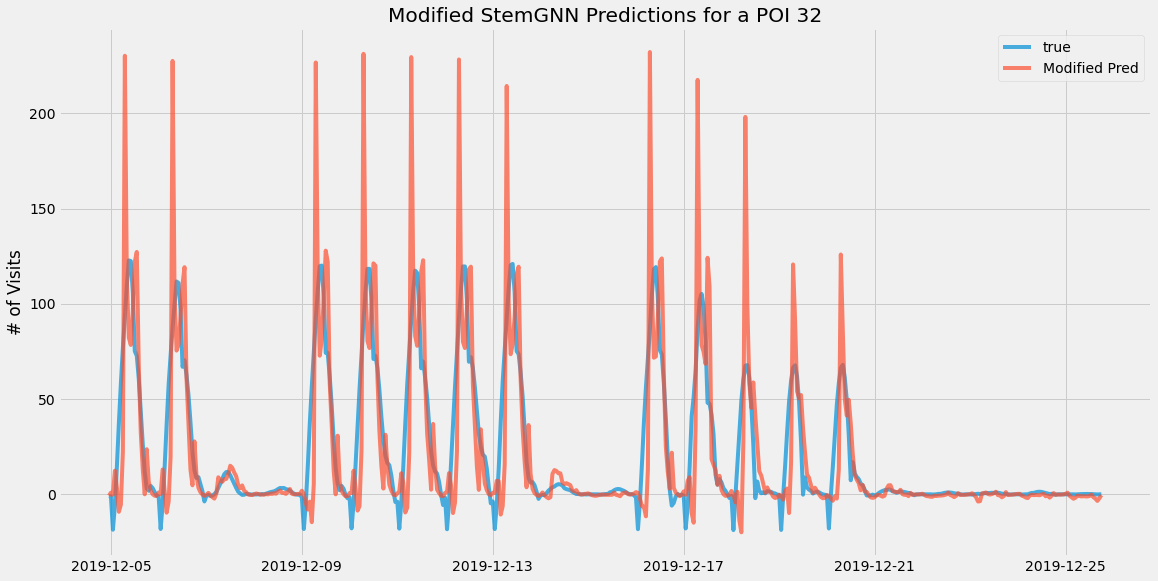

In [107]:
node_ind = 32
plt.style.use('fivethirtyeight')
fig, ax = plt.subplots(figsize=(16, 8))
plt.plot(preds_df.index[-500:], target_data[-500:, node_ind], label='true', alpha=0.7)
# plt.plot(preds_df.index[-500:], orig_preds_data[-500:, node_ind], label='Original Pred', alpha=0.7)
plt.plot(preds_df.index[-500:], cur_preds_data[-500:, node_ind], label='Modified Pred', alpha=0.7)
plt.legend()
plt.style.use('fivethirtyeight')
plt.grid(True)
plt.tight_layout()
# plt.xlabel('Time (Hour)')
plt.ylabel('# of Visits')
plt.title(f'Modified StemGNN Predictions for a POI {node_ind}')
plt.savefig(f"img/stem_gnn_comp_modified_2.png", bbox_inches = 'tight')

In [146]:
orig_preds_data

array([[ 1.14075152e+02,  3.24422727e+01,  9.68523705e+00, ...,
         9.59518565e-01, -1.83126590e-01, -1.63238451e-01],
       [ 7.51740288e+01,  2.02235401e+01,  8.88185819e+00, ...,
         6.05600271e-01,  3.61113357e-01, -9.11815404e-01],
       [ 6.86842183e+01,  1.58470334e+01,  2.39974956e+00, ...,
         3.22713070e-01,  6.25044583e-01, -3.18765609e+00],
       ...,
       [ 3.16392560e+02,  1.36104779e+02,  7.60188809e+01, ...,
         3.00185202e-01, -1.88729068e-01,  1.69057465e+00],
       [ 3.05696160e+02,  1.15582770e+02,  4.95527294e+01, ...,
        -1.16016925e-01, -7.97338475e-01,  4.10748883e+00],
       [ 2.51861753e+02,  9.72646357e+01,  3.30718280e+01, ...,
        -8.17647265e-01, -7.51377413e-01,  4.82493034e+00]])

In [147]:
cur_preds_data

array([[ 6.76339465e+01,  2.43455777e+01,  5.86892976e+00, ...,
        -2.09855503e-01,  6.68749007e-01, -1.83797910e-01],
       [ 6.46745868e+01,  2.13563844e+01,  1.86874006e+00, ...,
        -5.11788071e-01,  1.67399185e-01, -3.47930486e-01],
       [ 1.08224121e+02,  1.87513954e+01, -2.73806489e+00, ...,
        -4.23396507e-01,  7.94545111e-01, -8.88684954e-01],
       ...,
       [ 3.31167818e+02,  1.42004644e+02,  8.11400455e+01, ...,
         1.29377950e+00, -2.26039683e-01,  7.54345013e-01],
       [ 3.83574511e+02,  1.94307390e+02,  8.02177751e+01, ...,
         1.82528380e+00,  2.16858611e-01,  6.25538163e-01],
       [ 5.81425805e+02,  2.39742742e+02,  5.79904409e+01, ...,
         2.23948137e+00,  5.09654567e-01,  8.94726963e-01]])

In [105]:
pred_saved_path = f'/home/users/arash/NGA Project/POI/code/StemGNN/output/houston_data/train_0_410'
preds_data = np.genfromtxt(f'{pred_saved_path}/predict.csv', delimiter=',')
target_data = np.genfromtxt(f'{pred_saved_path}/target.csv', delimiter=',')

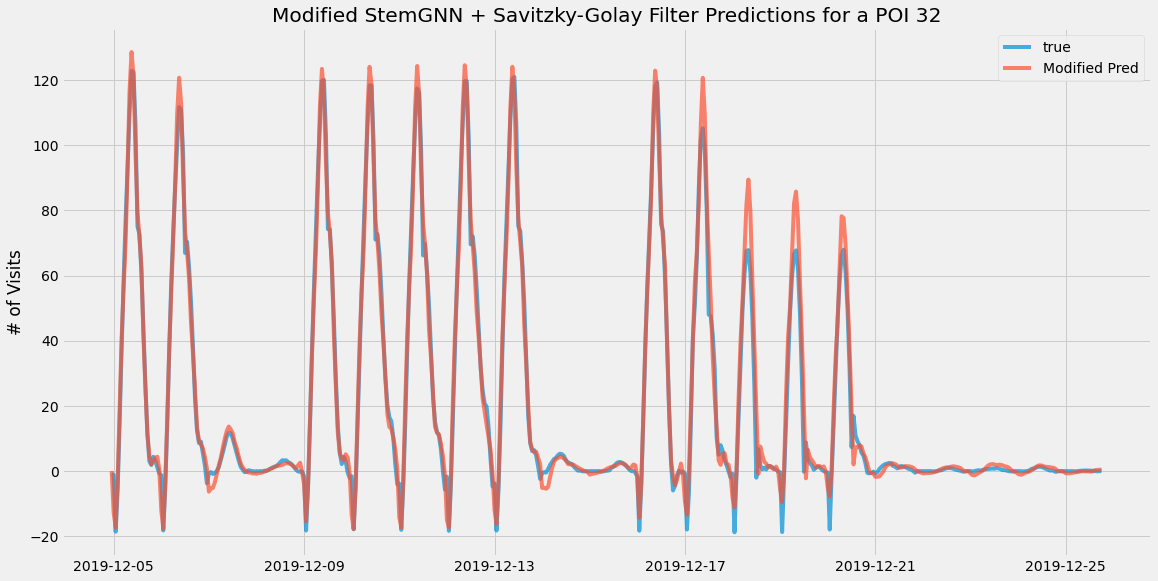

In [108]:
node_ind = 32
plt.style.use('fivethirtyeight')
fig, ax = plt.subplots(figsize=(16, 8))
plt.plot(preds_df.index[-500:], target_data[-500:, node_ind], label='true', alpha=0.7)
# plt.plot(preds_df.index[-500:], orig_preds_data[-500:, node_ind], label='Original Pred', alpha=0.7)
plt.plot(preds_df.index[-500:], preds_data[-500:, node_ind], label='Modified Pred', alpha=0.7)
plt.legend()
plt.style.use('fivethirtyeight')
plt.grid(True)
plt.tight_layout()
# plt.xlabel('Time (Hour)')
plt.ylabel('# of Visits')
plt.title(f'Modified StemGNN + Savitzky-Golay Filter Predictions for a POI {node_ind}')
plt.savefig(f"img/stem_gnn_modif_savgol_1.png", bbox_inches = 'tight')